# Interpreting CNNs

While deep learning, particularly CNNs, has demonstrated remarkable success in a wide range of applications, including self-driving cars, facial recognition, and more, a persistent lack of trust in their decision-making processes persists. Interpretability in CNNs is not only a matter of accountability but also has direct implications for improving model performance and reliability. Understanding how a neural network arrives at its decisions can provide valuable insights for model refinement and robustness. When we can interpret a model's behavior, we can identify potential shortcomings, biases, or overfitting, leading to more effective training strategies and model generalization.

The primary focus in this notebook is to introduce you to the Gradient-weighted Class Activation Mapping (Grad-CAM) technique, which offers a promising approach to enhancing model interpretability. By providing insights into the decision-making processes of CNNs, we can not only make these models more transparent and trustworthy but also improve their training and fine-tuning, ultimately advancing their performance and reliability in various applications.

The following cell runs setup code needed to get the Kaggle dataset for use in this notebook.

In [8]:
!rm -rf real_and_fake_face real_and_fake_face_detection processed
!pip -q install grad-cam

from google.colab import drive
from subprocess import Popen, PIPE
# makes files from your drive accessible
drive.mount('/content/drive', force_remount=True)

# TODO - specify path to your API key via google drive
api_key_filepath = "/content/drive/MyDrive/MDST/RvF/kaggle.json"


# Kaggle API Key setup ------------------
cmd = "mkdir /root/.kaggle"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
cmd = f"cp -f {api_key_filepath} /root/.kaggle/"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
cmd = f"chmod 600 /root/.kaggle/kaggle.json"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
# ------------------------------
!kaggle datasets download -d ciplab/real-and-fake-face-detection
!unzip -q real-and-fake-face-detection.zip

Mounted at /content/drive
 mkdir: cannot create directory ‘/root/.kaggle’: File exists

 
 
real-and-fake-face-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


## Grad-CAM

Grad-CAM was developed in 2016 by researchers as a method to visualize _what_ a convolutional neural network is paying attention to when it makes a certain prediction. This can be useful - if the CNN is paying attention to the wrong things, then it would imply the model is not learning the correct patterns and trends, and that work needs to be done to combat the generalization error.

The `pytorch-grad-cam` package offers a neat implementation for producing Grad-CAM visualizations for any convolutional neural network implemented in PyTorch.

To get started, load a trained model into your notebook. For this example, we will use the `weights.pth` file uploaded to the [data](https://github.com/MichiganDataScienceTeam/F23-RvF/blob/839738737fb9206609d7022c955bb03dff853187/data/weights.pth) folder on GitHub, download it to this notebook environment. The following cell does this for us:

In [1]:
!wget https://github.com/MichiganDataScienceTeam/F23-RvF/raw/main/data/weights.pth

import torch

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 4, 5, 2)
        self.conv2 = torch.nn.Conv2d(4, 8, 3, 1, padding="same")
        self.conv3 = torch.nn.Conv2d(8, 8, 3, 1, padding="same")
        self.conv4 = torch.nn.Conv2d(8, 8, 3, 1, padding="same")
        self.conv5 = torch.nn.Conv2d(8, 8, 3, 1, padding="same")
        self.dense1 = torch.nn.Linear(72, 24)
        self.dense2 = torch.nn.Linear(24, 2)

        self.pool = torch.nn.MaxPool2d(2,2)
        self.activation = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.init_weight()

    def init_weight(self):
        conv = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]
        dense = [self.dense1, self.dense2]

        for layer in conv:
            torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            torch.nn.init.zeros_(layer.bias)

        for layer in dense:
            torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            torch.nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.pool(self.activation(self.conv4(x)))
        x = self.pool(self.activation(self.conv5(x)))
        x = self.flatten(x)
        x = self.activation(self.dense1(x))
        return self.dense2(x)

model = Net()
model.load_state_dict(torch.load("./weights.pth", map_location=torch.device('cpu')), strict=False)

--2023-11-05 04:34:00--  https://github.com/MichiganDataScienceTeam/F23-RvF/raw/main/data/weights.pth
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MichiganDataScienceTeam/F23-RvF/main/data/weights.pth [following]
--2023-11-05 04:34:00--  https://raw.githubusercontent.com/MichiganDataScienceTeam/F23-RvF/main/data/weights.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21018 (21K) [application/octet-stream]
Saving to: ‘weights.pth’

weights.pth         100%[===================>]  20.53K  --.-KB/s    in 0.001s  

2023-11-05 04:34:00 (16.9 MB/s) - ‘weights.pth’ saved [21018/21018]



<All keys matched successfully>

From here, running visualizations on the dataset isn't very difficult! The following cell will:
- Load 100 images of fake faces
- Use our model to evaluate what the model pays attention to in _each_ of those fake faces when training the image via the Grad-CAM method
- Visualize these regions on the input image to give us intuition

In [63]:
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pathlib import Path
from tqdm import tqdm
import torchvision.transforms as tf

visualizations = []
cam = GradCAM(model=model, target_layers=[model.conv2, model.conv3])
# 0 = figure out what parts of the image make the model think face is fake
targets = [ClassifierOutputTarget(0)]

for image_path in tqdm(Path("./real_and_fake_face/training_fake").iterdir()):
    image = cv2.imread(str(image_path))
    pipeline = tf.Compose([
        tf.ToTensor(),
        tf.ConvertImageDtype(torch.float32),
        tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        tf.Resize((224,224))
    ])
    image = np.float32(image) / 255
    input_tensor = pipeline(image).view(1,3,224,224)

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    resized_image = cv2.resize(image, (224,224))
    visualization = show_cam_on_image(resized_image, grayscale_cam[0, :], use_rgb=True)
    visualizations.append(visualization)
    if len(visualizations) == 100:
        break

99it [00:03, 26.74it/s]


We can now take a look at the visualized images to see what the model is paying attention to.

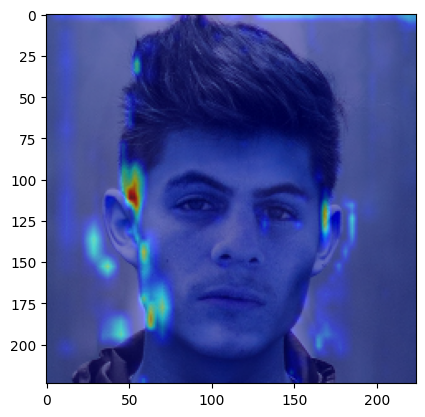

In [72]:
import matplotlib.pyplot as plt

plt.imshow(visualizations[0])

The lighter the color, the more the model pays attention to that part of the input image. In the example above, the model seems to be paying the most attention to the ears and the regions surrounding the ears.

This makes sense as the ears are the fake part of this face!

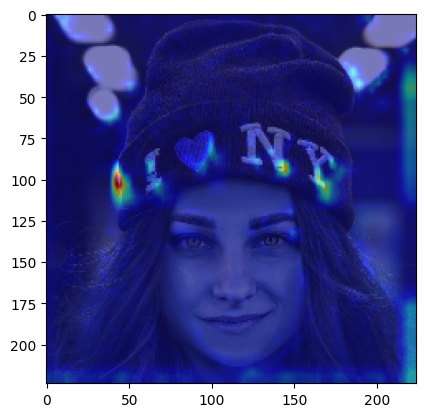

In [70]:
plt.imshow(visualizations[23])

This visualization is more interesting - for some reason, our model has learned that the "I ❤️ NY" and other features of the hat relate to a fake face, which is why it is paying attention to it!

This definitely not a relevant pattern that distinguishes a real face from a fake face, indicating that this model is **overfitting**!

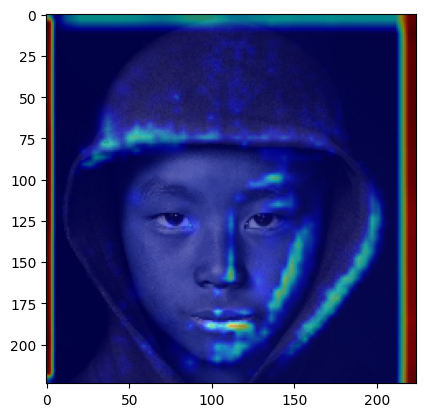

In [76]:
plt.imshow(visualizations[41])

This image also shows some of the similar patterns - for this face, the model seems to be paying attention to both facial features (like the nose, mouth, and face shape) but _also_ the hood of the sweater! The sweater hood likely doesn't have any association with a fake face, giving yet another indicator that this model is overfitting.

Even for the few cherry-picked examples, we can see immediately that the model doesn't seem to learn the real vs fake trends that we'd expect. Knowing exactly what the model has overfit to allows us to potentially fix the issue - this is the power of CNN interpretation methods like Grad-CAM!